In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy import linalg as LA
import matplotlib.cm as cm
plt.style.use("ggplot")

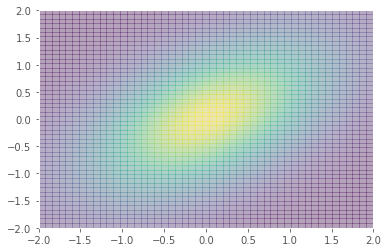

In [3]:
rho = 0.5

mu = np.array([0,0])
S = np.array([[1, rho],
              [rho, 1]])

def multi_gauss(x,y):
  return stats.multivariate_normal(mu, S).pdf([x,y])

X, Y = np.meshgrid(np.linspace(-2,2), np.linspace(-2,2))
Z = np.vectorize(multi_gauss)(X,Y)

plt.xlim(-2,2)
plt.ylim(-2,2)
plt.pcolor(X,Y,Z, alpha=0.3)
plt.show()

In [6]:
y=1
p_x = stats.norm(rho*y, 1-rho)
x = p_x.rvs(1)
print(x.data)

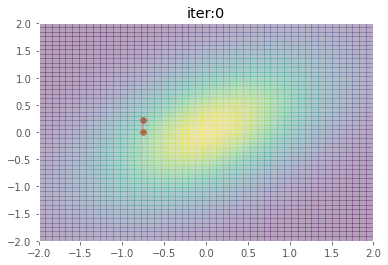

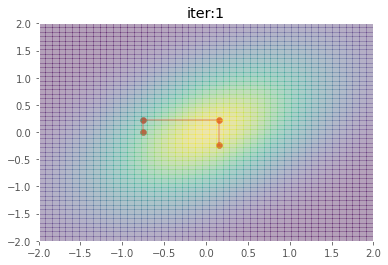

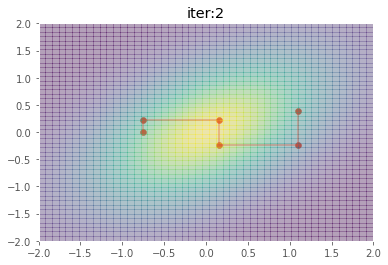

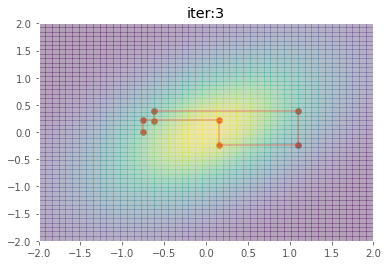

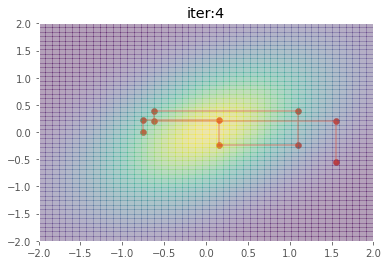

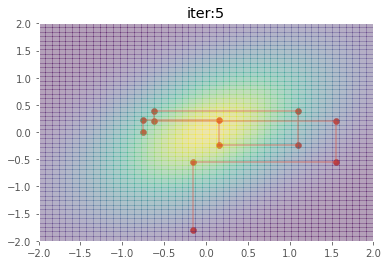

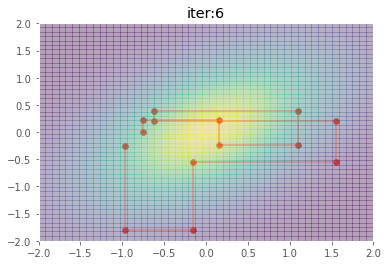

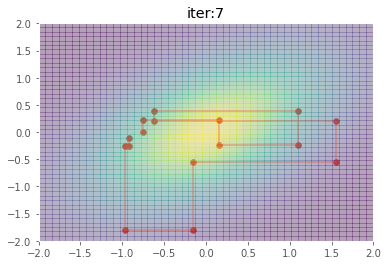

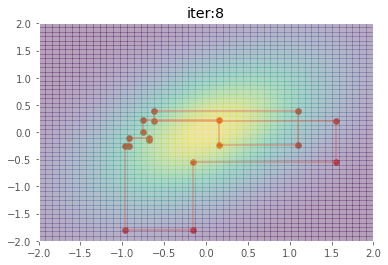

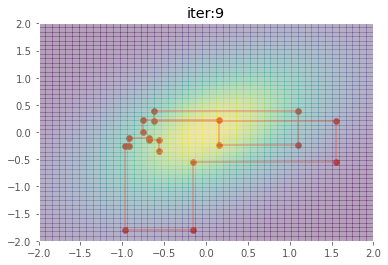

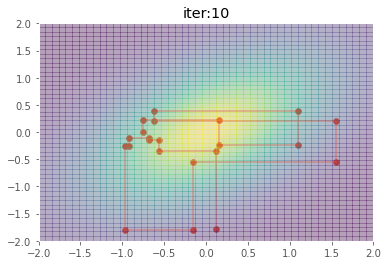

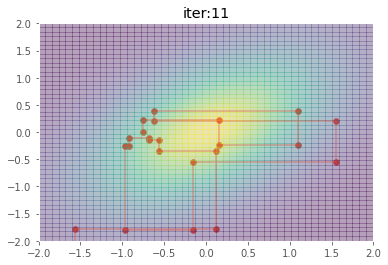

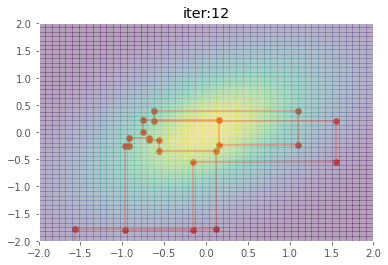

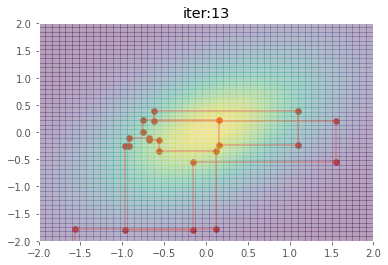

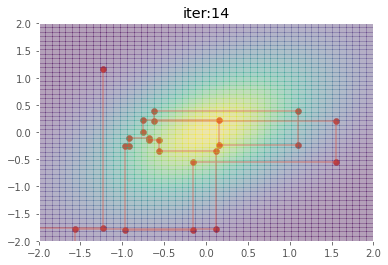

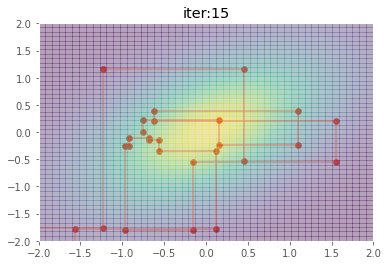

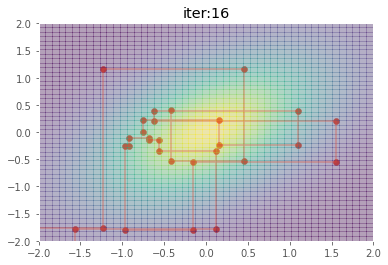

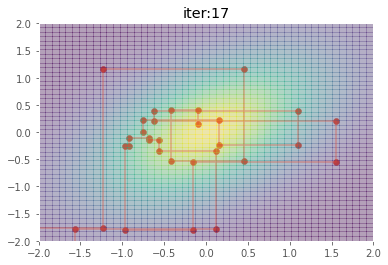

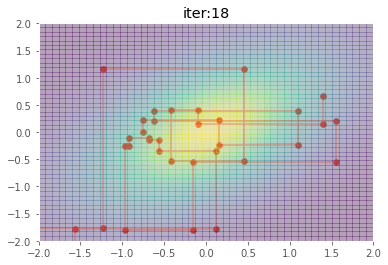

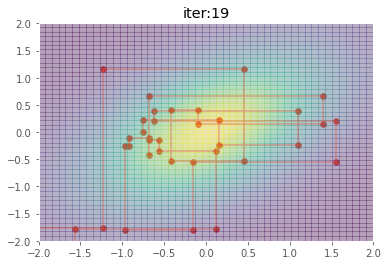

In [7]:
# 初期値
y = 0

sample_X = []
sample_Y = []
for i in range(20):
  p_x = stats.norm(rho*y, 1-rho**2)
  x = p_x.rvs(1)[0]
  sample_X.append(x)
  sample_Y.append(y)

  p_y = stats.norm(rho*x, 1-rho**2)
  y = p_y.rvs(1)[0]
  sample_X.append(x)
  sample_Y.append(y)

  plt.title(f"iter:{i}")
  plt.scatter(sample_X, sample_Y)
  plt.plot(sample_X,sample_Y, alpha=0.4)

  plt.xlim(-2,2)
  plt.ylim(-2,2)
  plt.pcolor(X,Y,Z, alpha=0.3)
  plt.show()

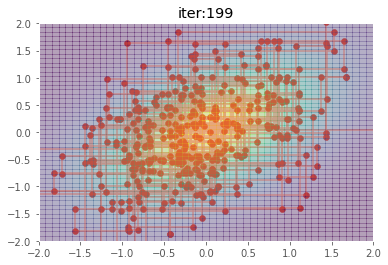

In [8]:
y = 0

sample_X = []
sample_Y = []
for i in range(200):
  p_x = stats.norm(rho*y, 1-rho**2)
  x = p_x.rvs(1)[0]
  sample_X.append(x)
  sample_Y.append(y)

  p_y = stats.norm(rho*x, 1-rho**2)
  y = p_y.rvs(1)[0]
  sample_X.append(x)
  sample_Y.append(y)

plt.title(f"iter:{i}")
plt.scatter(sample_X, sample_Y)
plt.plot(sample_X,sample_Y, alpha=0.4)

plt.xlim(-2,2)
plt.ylim(-2,2)
plt.pcolor(X,Y,Z, alpha=0.3)
plt.show()

In [11]:
print(np.array([sample_X]).mean(), np.array([sample_Y]).mean())

-0.12280527373401175 -0.08312383310857793


## ギブスサンプリングを使ってパラメータの事後分布を求める

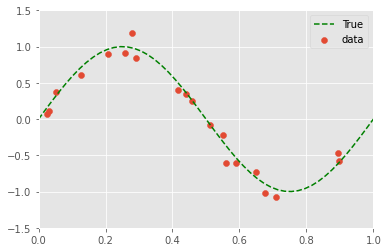

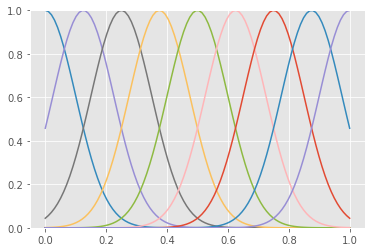

In [12]:
N = 20
np.random.seed(3)
train_X = np.random.uniform(0,1,N)
train_y = np.sin( 2*train_X*np.pi ) + np.random.normal(0,0.1, N)
plt.scatter(train_X, train_y, label="data")

plt.plot(np.linspace(0,1), np.sin(2 * np.pi * np.linspace(0,1)), "g--", label="True")
plt.xlim(0,1)
plt.ylim(-1.5,1.5)
plt.legend()
plt.show()

M = 10

def gaussian_basis(x):
  """
  feature function of gaussian.
  dimension of feature is M

  param x: numpy size=(1,1)
  return: size=(M)
  """
  gamma = 50
  x_ = np.linspace(0, 1, M-1)
  return np.append(1, np.exp( -(x - x_)**2 * gamma))

X = np.linspace(0,1,100)
Y = np.array([gaussian_basis(x) for x in X])
plt.plot(X,Y)
plt.ylim(0,1)
plt.show()

### 事前分布

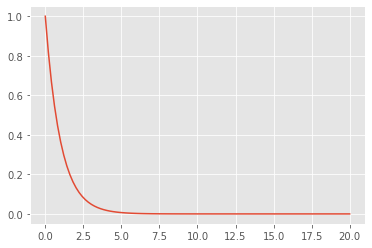

In [13]:
theta_0 = 1
a_0 = 1

x = np.linspace(0,20,100)
y = stats.gamma.pdf(x, a_0, scale=theta_0)
plt.plot(x,y)
plt.show()

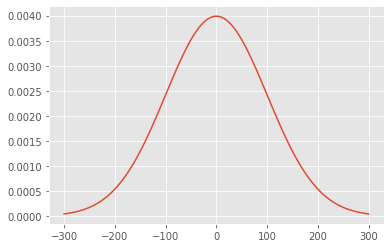

In [14]:
w_0 = np.zeros(M)
beta_0 = 1e-4
sigma_0 = np.sqrt(1/beta_0)

x = np.linspace(-300,300,100)
y = stats.norm.pdf(x, w_0[0], sigma_0)
plt.plot(x,y)
plt.show()

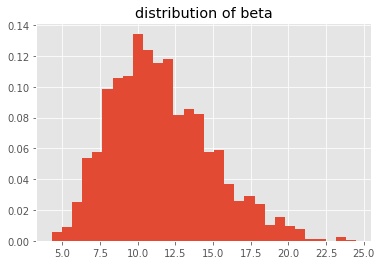

In [27]:
beta = 100

Phi = np.array([ gaussian_basis(x) for x in train_X] ) #(N, M)

sample_W = []
sample_beta = []
for i in range(2000):
  # w sampling
  S = LA.inv(beta*Phi.T@Phi + beta_0*np.eye(M))
  mu = S@(beta_0*w_0 + beta*Phi.T@train_y)
  p_w = stats.multivariate_normal(mu, S)
  w = p_w.rvs(1)

  # a sampling
  a = a_0 + N
  theta = theta_0 + (train_y - Phi@w).T@(train_y - Phi@w)
  p_a = stats.gamma(a/2., 2/theta)
  beta = p_a.rvs(1)[0]
  sample_W.append(w)
  sample_beta.append(beta)
  
sample_beta = np.array(sample_beta)
sample_W = np.array(sample_W)

plt.title("distribution of beta")
plt.hist(sample_beta, bins=30, density=True)
plt.show()

-5.836566346600044


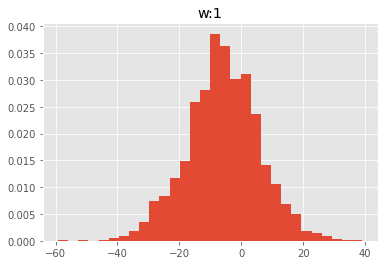

4.108515907320614


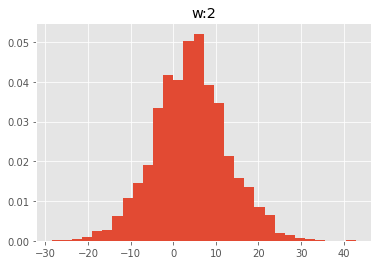

2.6679947806527733


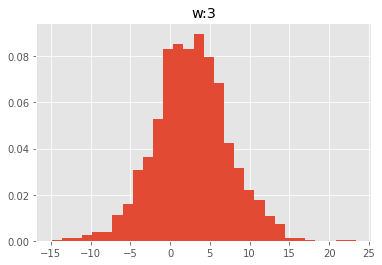

3.8479888797967043


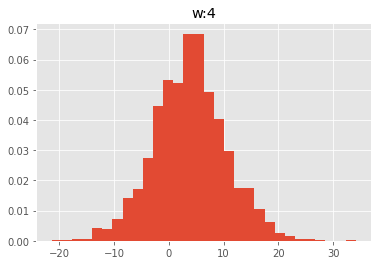

3.121153424545315


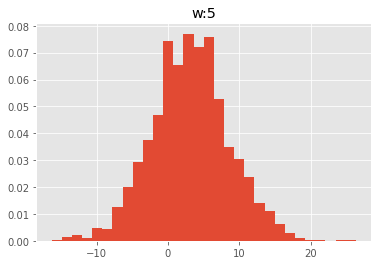

3.0369658708598353


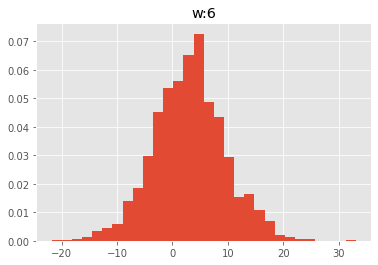

2.29973809616204


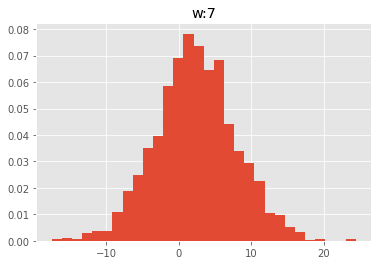

2.570203337789081


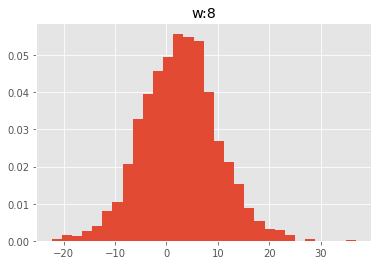

1.4565452429980579


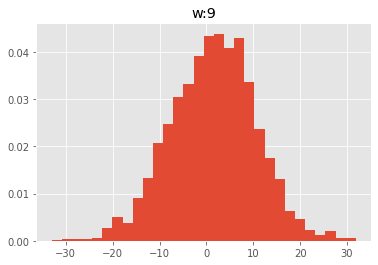

5.071056987225667


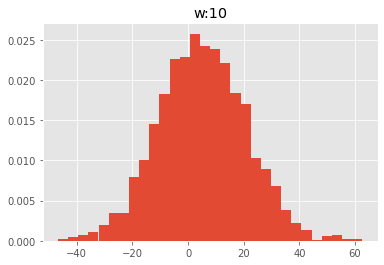

In [28]:
for i in range(M):
  plt.title(f"w:{i+1}")
  plt.hist(sample_W[:,i], bins=30, density=True)
  print(sample_W[:,i].mean())
  plt.show()

### 得られた分布からMAP推定をする

In [21]:
sample_beta

array([ 8.42153653, 10.96241557,  6.38969548, ...,  7.25380939,
        7.31668182,  9.72857617])

In [20]:
np.histogram(sample_beta)

(array([ 42, 246, 486, 484, 368, 199, 111,  45,  15,   4]),
 array([ 3.07439755,  5.15336972,  7.23234189,  9.31131407, 11.39028624,
        13.46925842, 15.54823059, 17.62720276, 19.70617494, 21.78514711,
        23.86411929]))

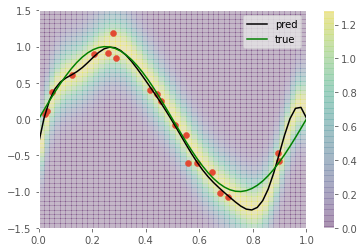

In [29]:
beta_map = np.histogram(sample_beta)[1][np.histogram(sample_beta)[0].argmax()]
w_map = sample_W.mean(0)

def norm_map(x,y):
  return stats.norm(w_map.T@gaussian_basis(x), np.sqrt(1/beta_map)).pdf(y)

x_, y_ = np.meshgrid(np.linspace(0,1), np.linspace(-1.5,1.5))
Z = np.vectorize(norm_map)(x_, y_)

plt.pcolor(x_,y_,Z, alpha=0.2)
plt.colorbar()
plt.scatter(train_X, train_y)

X = np.linspace(0,1)
y = [w_map.T@gaussian_basis(x) for x in X]
plt.plot(X, y, c="k", label="pred")
plt.xlim(0, 1)
plt.ylim(-1.5, 1.5)
 
#本物の分布
plt.plot(np.linspace(0,1), np.sin(2 * np.pi * np.linspace(0,1)), c ="g", label="true")
 
plt.legend()
plt.show()

### Beysian 推定

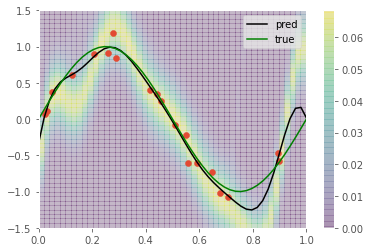

In [31]:
def norm_bayes(x,y,w,beta):
  return stats.norm(w@gaussian_basis(x), np.sqrt(1/beta)).pdf(y)

Z = 0
sample_num = 20
burnin = 500
for i in range(sample_num):
  x_, y_ = np.meshgrid(np.linspace(0,1), np.linspace(-1.5, 1.5))
  Z += np.vectorize(lambda x,y: norm_bayes(x,y,sample_W[burnin+10*i],sample_beta[burnin+10*i]))(x_,y_)
  Z /= sample_num

plt.pcolor(x_, y_, Z, alpha=0.2)
plt.colorbar()
plt.scatter(train_X, train_y)

x = np.linspace(0,1)
y = [w_map.dot(gaussian_basis(x__)) for x__ in x]
plt.plot(x,y,c="k",label="pred")
plt.xlim(0, 1)
plt.ylim(-1.5, 1.5)
 
#本物の分布
plt.plot(np.linspace(0,1), np.sin(2 * np.pi * np.linspace(0,1)), c ="g", label="true")
plt.legend()
plt.show()